# Credit Risk Analysis/Loan approval

##### The purpose of Credit Risk Analysis is to determine the creditworthiness of the borrower on the basis of certain parameters financial history, repayment history. So basically it is about checking if the person is eligible to receive the amount of money he is requesting without causing any loss to the investor. 
##### CRA helps the investors to target the right customer to invest in and analyze the risk involved to make the business more profitable.


> Removing Duplicates
> Checking for outliers and removing them
> Use Column Transfer and Pipeline to streamline process
> Use Randomized Search to find optimal set of parameters
> Automate the procedure for multiple classfiers
> checking fo over and underfitting

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report


In [5]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
df.shape

(32581, 12)

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.shape

(32416, 12)

In [9]:
x_train,x_test,y_train,y_test = train_test_split(df.drop('loan_status',axis = 1),
                                                        df['loan_status'],
                                                        random_state = 0, 
                                                        test_size = 0.2,
                                                        stratify = df['loan_status'],
                                                        shuffle = True)

In [10]:
df['loan_status'].value_counts(normalize = True)

0    0.781312
1    0.218688
Name: loan_status, dtype: float64

In [11]:
y_train.value_counts(normalize = True)

0    0.781313
1    0.218687
Name: loan_status, dtype: float64

In [12]:
x_train.isna().sum()*100/x_train.shape[0]

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.799630
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.613605
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [13]:
x_train.shape

(25932, 11)

In [14]:
x_train.dropna().shape

(22763, 11)

In [15]:
(25932-22763)/25932

0.12220422643837729

In [16]:
#12 % of the values are getting removed

In [17]:
x_train[['person_income', 'loan_amnt', 'loan_percent_income']].head()

,person_income,loan_amnt,loan_percent_income
21415,48000,10000,0.21
12916,85000,7500,0.09
2938,125000,3000,0.02
19114,62000,2300,0.04
6057,48000,4200,0.09


In [18]:
x_train.drop('loan_percent_income', axis=1, inplace=True)
x_test.drop('loan_percent_income', axis=1, inplace=True)

In [19]:
for col in x_train:
    print(col, '>>',x_train[col].nunique())
    if x_train[col].nunique()<20:
        print(x_train[col].value_counts(normalize = True)*100)
    print()

person_age >> 58

person_income >> 3680

person_home_ownership >> 4
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: person_home_ownership, dtype: float64

person_emp_length >> 36

loan_intent >> 6
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: loan_intent, dtype: float64

loan_grade >> 7
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: loan_grade, dtype: float64

loan_amnt >> 710

loan_int_rate >> 346

cb_person_default_on_file >> 2
N    82.392411
Y    17.607589
Name: cb_person_default_on_file, dtype: float64

cb_person_cred_hist_length >> 29



In [20]:
x_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
count,25932.000000,2.593200e+04,25206.000000,25932.000000,23439.000000,25932.000000
mean,27.721155,6.589884e+04,4.811315,9611.395187,11.013784,5.793460
std,6.382311,6.333831e+04,4.172822,6339.054572,3.240104,4.052297
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,2.000000
25%,23.000000,3.849500e+04,2.000000,5000.000000,7.900000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,4.000000
75%,30.000000,7.900000e+04,7.000000,12250.000000,13.480000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,30.000000


In [21]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25932 entries, 21415 to 6848
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  25932 non-null  int64  
 1   person_income               25932 non-null  int64  
 2   person_home_ownership       25932 non-null  object 
 3   person_emp_length           25206 non-null  float64
 4   loan_intent                 25932 non-null  object 
 5   loan_grade                  25932 non-null  object 
 6   loan_amnt                   25932 non-null  int64  
 7   loan_int_rate               23439 non-null  float64
 8   cb_person_default_on_file   25932 non-null  object 
 9   cb_person_cred_hist_length  25932 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 2.2+ MB


In [22]:
numerical_features = [feature for feature in x_train if x_train[feature].dtypes != 'O']
numerical_features

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length']

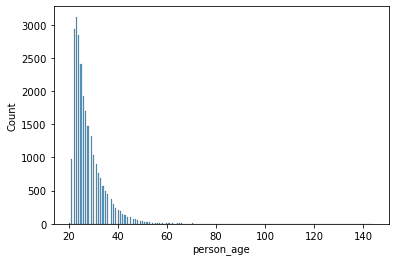

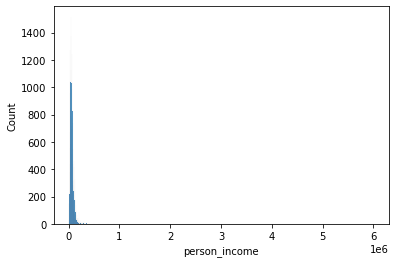

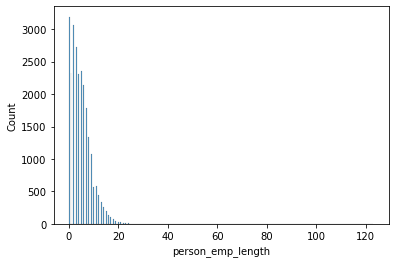

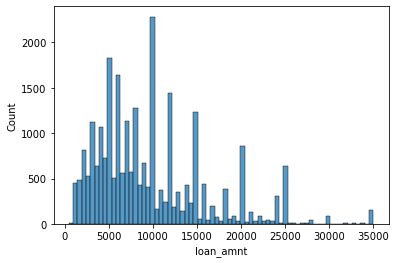

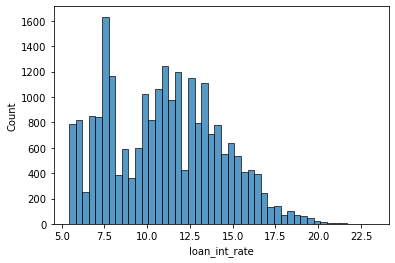

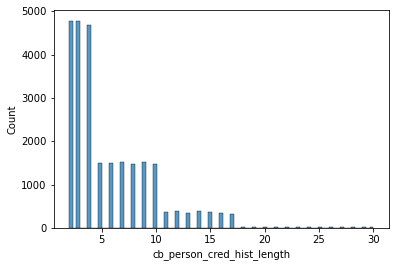

In [23]:
for feature in numerical_features:
    sns.histplot(x_train[feature])
    plt.show()

In [28]:
x_train.loc[x_train['person_age']>=80,:]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length


In [29]:
x_train = x_train.loc[x_train['person_age']<80,:]

In [30]:
x_train.shape

(25924, 10)

In [31]:
x_train.loc[x_train['person_emp_length']>=66, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,Y,3


In [32]:
df.query("person_age<=person_emp_length+14")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [33]:
x_train = x_train.loc[(x_train['person_emp_length']<66) | (x_train['person_emp_length'].isna()), :]

In [34]:
#updating y values
y_train = y_train[x_train.index]

In [35]:
categorical_features = [feature for feature in x_train if x_train[feature].dtypes=='O']
categorical_features

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [36]:
num_pipe = Pipeline([
    ('impute',IterativeImputer()),
    ('scalar',StandardScaler())
])

In [37]:
ct = ColumnTransformer([
    ('num_pipe',num_pipe,numerical_features),
    ('categorical_features',OneHotEncoder(sparse=False,handle_unknown='ignore'),categorical_features)
],remainder='passthrough')

In [38]:
from lightgbm import LGBMClassifier

In [39]:

grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[300,400,500],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
    
    LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
}

In [40]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}


LGBMClassifier(class_weight='balanced', random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'model__learning_rate': [0.001, 0.01, 0.1, 1, 10], 'model__boosting_type': ['gbdt', 'goss', 'dart'], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [45]:
full_df = pd.DataFrame()
best_algos = {}

In [47]:
for clf, param in grid.items():
    pipe = Pipeline([('coltf',ct),('model',clf)])
    gs = RandomizedSearchCV(estimator = pipe,param_distributions = param, scoring = 'accuracy',n_jobs = -1, verbose = 3, n_iter=4,random_state = 0)
    gs.fit(x_train,y_train)
    all_res = pd.DataFrame(gs.cv_results_)
    temp = all_res.loc[:,['params','mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo']=algo_name
    full_df = pd.concat([full_df,temp],ignore_index = True)
    best_algos[algo_name]=gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [48]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
2,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
1,"{'model__n_estimators': 500, 'coltf__num_pipe_...",0.922537,RandomForestClassifier
0,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.922074,RandomForestClassifier
3,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.921650,RandomForestClassifier
7,"{'model__n_estimators': 300, 'model__learning_...",0.908572,LGBMClassifier
4,"{'model__n_estimators': 300, 'model__learning_...",0.869146,LGBMClassifier
5,"{'model__n_estimators': 300, 'model__learning_...",0.868683,LGBMClassifier
6,"{'model__n_estimators': 300, 'model__learning_...",0.863784,LGBMClassifier


In [49]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

{'model__n_estimators': 400,
 'coltf__num_pipe__impute__estimator': LinearRegression()}

In [50]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('categorical_features',
                                                  O

In [52]:
be.fit(x_train, y_train)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('categorical_features',
                                                  O

In [53]:
preds = be.predict(x_test)

In [54]:
confusion_matrix(y_test, preds)

array([[5006,   60],
       [ 435,  983]], dtype=int64)

C:\Users\satguru\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


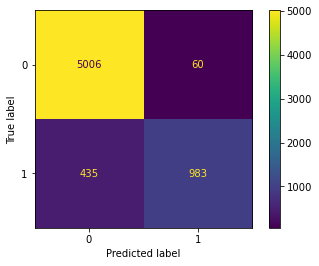

In [55]:
plot_confusion_matrix(be, x_test, y_test)

In [56]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      5066
           1       0.94      0.69      0.80      1418

    accuracy                           0.92      6484
   macro avg       0.93      0.84      0.88      6484
weighted avg       0.92      0.92      0.92      6484



In [59]:
be.score(x_test, y_test)

0.9236582356570019

Precision Recall Curve

C:\Users\satguru\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


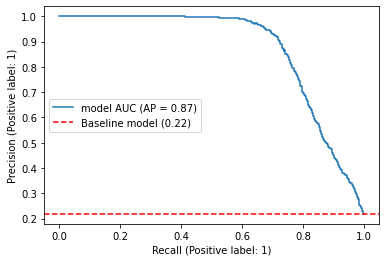

In [62]:
plot_precision_recall_curve(estimator=be, X=x_test, y=y_test, name='model AUC')
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

Learning Curve

In [64]:
a, b, c = learning_curve(be, x_train, y_train, n_jobs=-1, scoring='accuracy')

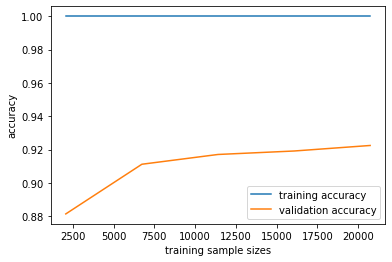

In [65]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()

Overfitting
> high traning accuracy
> low testing accuracy
> big gap between training and testinc curve
> model is too complex for the data

In [69]:
grid = {
    
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[100,200,300],
     'model__max_depth':[5, 9, 13],
     'model__min_samples_split':[4,6,8],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]}
}

In [70]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [100, 200, 300], 'model__max_depth': [5, 9, 13], 'model__min_samples_split': [4, 6, 8], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [72]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4)
    
    gs.fit(x_train, y_train)
    
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp])
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [74]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
0,"{'model__n_estimators': 200, 'model__min_sampl...",0.864054,RandomForestClassifier
2,"{'model__n_estimators': 100, 'model__min_sampl...",0.812630,RandomForestClassifier
1,"{'model__n_estimators': 300, 'model__min_sampl...",0.809776,RandomForestClassifier
3,"{'model__n_estimators': 300, 'model__min_sampl...",0.809428,RandomForestClassifier


In [75]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('categorical_features',
                                                  O

In [76]:
be.fit(x_train, y_train)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('categorical_features',
                                                  O

In [77]:
preds = be.predict(x_test)

In [78]:
confusion_matrix(y_test, preds)

array([[4497,  569],
       [ 304, 1114]], dtype=int64)

C:\Users\satguru\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


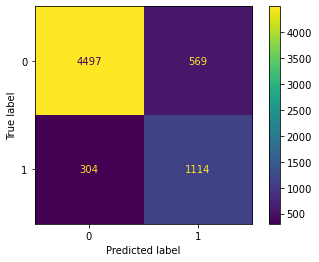

In [79]:
plot_confusion_matrix(be, x_test, y_test)

In [80]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      5066
           1       0.66      0.79      0.72      1418

    accuracy                           0.87      6484
   macro avg       0.80      0.84      0.82      6484
weighted avg       0.88      0.87      0.87      6484



In [82]:
be.score(x_test, y_test)

0.8653608883405305

C:\Users\satguru\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


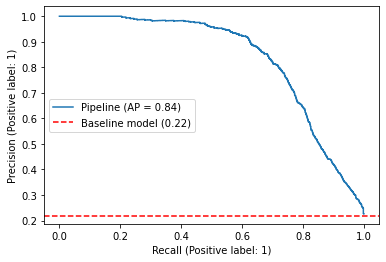

In [84]:
plot_precision_recall_curve(be, x_test, y_test)
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

In [86]:
a, b, c = learning_curve(be, x_train, y_train, n_jobs=-1, cv=5)

In [87]:
a

array([ 2073,  6739, 11405, 16071, 20737])

In [88]:
b

array([[0.93294742, 0.93680656, 0.93680656, 0.93680656, 0.93680656],
       [0.91096602, 0.90874017, 0.91170797, 0.91170797, 0.91170797],
       [0.89715037, 0.89864095, 0.90644454, 0.89355546, 0.89355546],
       [0.8858814 , 0.8845747 , 0.88725033, 0.89303715, 0.8931616 ],
       [0.87785118, 0.88084101, 0.87992477, 0.88508463, 0.88190191]])

In [89]:
c

array([[0.8584378 , 0.8756027 , 0.88155864, 0.87191358, 0.87750772],
       [0.87270974, 0.87270974, 0.88599537, 0.87924383, 0.87692901],
       [0.86962392, 0.87270974, 0.88580247, 0.87037037, 0.86766975],
       [0.86306654, 0.86287367, 0.87345679, 0.87307099, 0.86747685],
       [0.85689489, 0.8611379 , 0.87191358, 0.87191358, 0.86207562]])

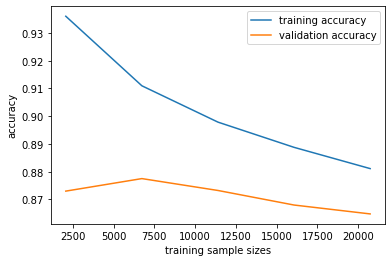

In [90]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()